In [ ]:
import os
# Define Paths and Configuration
DRIVE_CONE_DIR = '/content/drive/MyDrive/AMP/Synthetic_Data/AKS_cones'
LOCAL_CONE_DIR = '/tmp/AKS_cones'
MASK_DIR = os.path.join(LOCAL_CONE_DIR, 'masks')
CROPPED_DIR = os.path.join(LOCAL_CONE_DIR, 'cropped_images')

AMP_DIR = '/content/drive/MyDrive/AMP/Synthetic_Data/AMP_model_1.v2i.yolov8'
BG_IMAGE_DIR = os.path.join(AMP_DIR, 'train/images')
BG_LABEL_DIR = os.path.join(AMP_DIR, 'train/labels')

# Define Output Directories (where new data will be saved)
OUTPUT_DIR = '/content/drive/MyDrive/AMP/Synthetic_Data/Generated_Data'
OUTPUT_IMG_DIR = os.path.join(OUTPUT_DIR, 'images')
OUTPUT_LABEL_DIR = os.path.join(OUTPUT_DIR, 'labels')

# Create output directories if they don't exist
os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)

# Configuration Variables
DRIVABLE_CLASS_ID = 0
CONE_CLASS_ID = 1

NUM_IMAGES_TO_PROCESS = 5
MIN_CONES_PER_IMG = 1
MAX_CONES_PER_IMG = 3
MIN_CONE_SCALE = 0.04
MAX_CONE_SCALE = 0.15

print(f"--- Configuration ---")
print(f"Loading backgrounds from: {BG_IMAGE_DIR}")
print(f"Cone source (on Drive): {DRIVE_CONE_DIR}")
print(f"Cone destination (local): {LOCAL_CONE_DIR}")
print(f"Saving synthetic data to: {OUTPUT_DIR}")
print(f"*** NEW CONFIG ***")
print(f"Drivable Area Class ID: {DRIVABLE_CLASS_ID} (Class 0)")
print(f"New Cone Class ID: {CONE_CLASS_ID} (Class 1)")

--- Configuration ---
Loading backgrounds from: /content/drive/MyDrive/AMP/Synthetic_Data/AMP_model_1.v2i.yolov8/train/images
Cone source (on Drive): /content/drive/MyDrive/AMP/Synthetic_Data/AKS_cones
Cone destination (local): /tmp/AKS_cones
Saving synthetic data to: /content/drive/MyDrive/AMP/Synthetic_Data/Generated_Data
*** NEW CONFIG ***
Drivable Area Class ID: 0 (Class 0)
New Cone Class ID: 1 (Class 1)


In [ ]:
import time

print(f"Copying cone assets from {DRIVE_CONE_DIR} to {LOCAL_CONE_DIR}...")
print("This may take a few minutes, but it's a one-time operation.")
start_time = time.time()

!cp -r "{DRIVE_CONE_DIR}" "{LOCAL_CONE_DIR}"

copy_time = time.time() - start_time
print(f"Copy complete in {copy_time:.2f} seconds.")

# Verification
if os.path.exists(MASK_DIR):
    print(f"Success! Found {len(os.listdir(MASK_DIR))} masks in local storage.")
else:
    print(f"[!! ERROR !!] Could not find local mask dir: {MASK_DIR}")

Copying cone assets from /content/drive/MyDrive/AMP/Synthetic_Data/AKS_cones to /tmp/AKS_cones...
This may take a few minutes, but it's a one-time operation.
Copy complete in 152.25 seconds.
Success! Found 5150 masks in local storage.


In [ ]:
# Helper Function for Cropping
def crop_mask_to_content(mask):
    """
    Finds the bounding box of all white pixels in a mask and crops it.
    Returns the cropped mask.
    """
    # Find all non-zero (white) pixels
    # np.argwhere returns (y, x) coordinates
    y_coords, x_coords = np.where(mask > 0)

    if len(y_coords) == 0:
        # Mask is all black
        return None

    # Find the min/max (y, x) to create a bounding box
    y_min, y_max = np.min(y_coords), np.max(y_coords)
    x_min, x_max = np.min(x_coords), np.max(x_coords)

    # +1 because slicing is exclusive on the high end
    cropped_mask = mask[y_min : y_max + 1, x_min : x_max + 1]

    return cropped_mask

print("Helper function `crop_mask_to_content` defined.")

Helper function `crop_mask_to_content` defined.


In [ ]:
# Auto-Cropping Masks

cone_assets = []

try:
    mask_files = os.listdir(MASK_DIR)
except FileNotFoundError:
    print(f"[!! ERROR !!] MASK_DIR not found at: {MASK_DIR}")
    raise

print(f"Loading and auto-cropping masks from {MASK_DIR}...")
print(f"Looking for matching images in {CROPPED_DIR}...")

loaded_count = 0
skipped_no_image = 0
skipped_mismatch = 0
skipped_all_black = 0

for mask_filename in mask_files:
    if not (mask_filename.endswith('.png') or mask_filename.endswith('.jpg')):
        continue # Skip non-image files

    # Load the FULL-SIZE mask
    mask_path = os.path.join(MASK_DIR, mask_filename)
    full_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if full_mask is None:
        print(f"  [Warning] Could not load mask: {mask_filename}")
        continue

    # Binarize the full-size mask
    # Any pixel > 0 becomes 255 (white)
    _, full_mask_binary = cv2.threshold(full_mask, 0, 255, cv2.THRESH_BINARY)

    # Auto-crop the mask to its content
    cropped_mask = crop_mask_to_content(full_mask_binary)

    if cropped_mask is None:
        # This mask was all black
        skipped_all_black += 1
        continue

    # Find and load the matching pre-cropped IMAGE
    image_path = os.path.join(CROPPED_DIR, mask_filename)

    if not os.path.exists(image_path):
        skipped_no_image += 1
        continue

    cone_img = cv2.imread(image_path)

    if cone_img is None:
        print(f"  [Warning] Could load mask, but not image: {mask_filename}")
        continue

    if cone_img.shape[:2] != cropped_mask.shape[:2]:
        skipped_mismatch += 1
        continue

    cone_assets.append((cone_img, cropped_mask))
    loaded_count += 1

print("\n--- Asset Loading Complete ---")
print(f"Successfully loaded {loaded_count} valid cone assets.")
if skipped_no_image > 0:
    print(f"Skipped {skipped_no_image} masks (no matching image file found in CROPPED_DIR).")
if skipped_mismatch > 0:
    print(f"Skipped {skipped_mismatch} assets (pre-cropped image and auto-cropped mask shapes did not match).")
if skipped_all_black > 0:
    print(f"Skipped {skipped_all_black} masks (mask file was all black).")

if not cone_assets:
    print("\n[!!! CRITICAL ERROR !!!]")
    print("No valid cone assets were loaded. The script cannot continue.")

In [ ]:
# Helper Functions (YOLO & Masks)

def load_yolo_segmentation(filepath, img_w, img_h):
    """
    Loads YOLOv8 segmentation data from a .txt file.
    Returns: A list of (class_id, pixel_polygon) tuples.
    """
    annotations = []
    try:
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 2:
                    continue

                class_id = int(parts[0])

                # Convert normalized [x1 y1 x2 y2...] to pixel coords [N, 2]
                norm_coords = np.array([float(p) for p in parts[1:]]).reshape(-1, 2)
                pixel_coords = (norm_coords * [img_w, img_h]).astype(np.int32)

                annotations.append((class_id, pixel_coords))
    except Exception as e:
        print(f"  [Warning] Error loading label {filepath}: {e}")
    return annotations


def get_spawnable_mask(annotations, img_h, img_w):
    """
    Creates a binary mask (0 or 1) of the valid spawn region.
    This is the INTERSECTION of:
    1. The 'drivable_area' polygons.
    2. The 1/4 vertical region (50% to 75% of image height).
    """

    # 1. Create the drivable_area mask
    drivable_mask = np.zeros((img_h, img_w), dtype=np.uint8)
    drivable_polygons = [poly for class_id, poly in annotations
                        if class_id == DRIVABLE_CLASS_ID]

    if not drivable_polygons:
        # No drivable area found in this label file
        return None

    cv2.fillPoly(drivable_mask, drivable_polygons, 1) # '1' = drivable

    # 2. Create the vertical region mask (Constraint 2)
    vertical_mask = np.zeros((img_h, img_w), dtype=np.uint8)

    # "1/4 region right under the half way point"
    y_start = int(img_h * 0.50)  # 50% down
    y_end = int(img_h * 0.75)    # 75% down

    vertical_mask[y_start:y_end, :] = 1 # '1' = valid vertical region

    # 3. Find the intersection
    # The final mask is '1' ONLY where BOTH masks are '1'
    spawnable_mask = cv2.bitwise_and(drivable_mask, vertical_mask)

    return spawnable_mask


def save_yolo_segmentation(filepath, annotations, img_w, img_h):
    """
    Saves a list of (class_id, polygon_pixels) to a YOLOv8 .txt file.
    """
    with open(filepath, 'w') as f:
        for class_id, pixel_coords in annotations:
            # Ensure coords are valid
            if len(pixel_coords) < 3:
                continue

            # Normalize pixel_coords
            norm_coords = pixel_coords.astype(np.float32)
            norm_coords[:, 0] = np.clip(norm_coords[:, 0] / img_w, 0, 1) # Normalize x
            norm_coords[:, 1] = np.clip(norm_coords[:, 1] / img_h, 0, 1) # Normalize y

            # Flatten to 'x1 y1 x2 y2...'
            coord_str = " ".join([f"{coord:.6f}" for coord in norm_coords.flatten()])
            f.write(f"{class_id} {coord_str}\n")

print("Helper functions defined: load_yolo_segmentation, get_spawnable_mask, save_yolo_segmentation")

Helper functions defined: load_yolo_segmentation, get_spawnable_mask, save_yolo_segmentation


In [ ]:
# Synchronized Augmentations

def augment_and_resize_cone(cone_asset, img_h):
    """
    Applies conditional scaling:
    - If mask area is ~1100 pixels, try to scale by 2.5x
    - ...UNLESS the new area would be > 10,000 pixels, then scale by 2.0x
    - Otherwise, do not scale (1.0x)
    Then, applies random augmentations.
    """
    cone_img, cone_mask = cone_asset

    # Conditional Scaling

    # Get the white pixel count (area) of the *original* mask
    white_pixel_count = cv2.countNonZero(cone_mask)
    orig_h, orig_w = cone_img.shape[:2]

    # Define target range
    min_area = 1000
    max_area = 1200

    scale_factor = 1.0 # Default to no scaling

    # Check if the mask area is in target range
    if min_area <= white_pixel_count <= max_area:
        # Default to 2.5x for this range
        scale_factor = 2.5
        print(f"  [Debug] Cone area {white_pixel_count} is in range. Base scale: 2.5x.")

        # Check if the 2.5x size is too big
        # Calculate potential new dimensions and area
        potential_w = int(orig_w * scale_factor)
        potential_h = int(orig_h * scale_factor)
        potential_area = potential_w * potential_h

        if potential_area > 10000:
            print(f"  [Debug] Area at 2.5x ({potential_area}) > 10000. Reducing scale to 2.0x.")
            scale_factor = 2.0 # Reduce scale as requested

    else:
        # This will apply to all other cones
        scale_factor = 1.0
        # print(f"  [Debug] Cone area {white_pixel_count} is not in range. Applying 1.0x scale.")

    # Calculate final dimensions
    new_w = int(orig_w * scale_factor)
    new_h = int(orig_h * scale_factor)

    if new_h < 1 or new_w < 1:
        return None, None # Safety check

    # Resize
    if scale_factor == 1.0:
        # No resize needed, just copy
        cone_scaled = cone_img.copy()
        mask_scaled = cone_mask.copy()
    else:
        # Apply the calculated resize
        print(f"  [Debug] Resizing cone from {orig_w}x{orig_h} to {new_w}x{new_h}.")
        cone_scaled = cv2.resize(cone_img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        mask_scaled = cv2.resize(cone_mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # Augmentations (on the scaled images)
    cone_aug = cone_scaled.copy()
    mask_aug = mask_scaled.copy()

    # Random Brightness/Contrast
    brightness = random.randint(-25, 25)
    contrast = random.uniform(0.9, 1.1)
    cone_aug = cv2.addWeighted(cone_aug, contrast, cone_aug, 0, brightness)
    cone_aug = np.clip(cone_aug, 0, 255).astype(np.uint8)

    # Random Horizontal Flip
    if random.random() > 0.5:
        print("  [Debug] Applying horizontal flip to image AND mask.")
        cone_aug = cv2.flip(cone_aug, 1)
        mask_aug = cv2.flip(mask_aug, 1)
    else:
        print("  [Debug] No flip applied.")

    # Binarize mask again
    _, mask_aug = cv2.threshold(mask_aug, 127, 255, cv2.THRESH_BINARY)

    return cone_aug, mask_aug

--- STARTING PREVIEW MODE ---
Loading one random image to process...
Processing: img-1345-_jpg.rf.6f5940f1e31233da1abb1b514f46cd68.jpg
  Attempting to spawn 1 cone(s)...
----------------------------------------
  [Debug] Applying horizontal flip to image AND mask.

--- PREVIEW: Asset for Cone 1 (Scaled/Augmented) ---
  (This is the small image being pasted, size: 65x116)


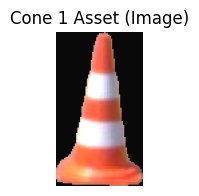


--- PREVIEW: Mask for Cone 1 (Scaled/Augmented) ---
  (This is the small MASK being used, size: 65x116)
  [Debug] White Pixel Count in this asset: 3677


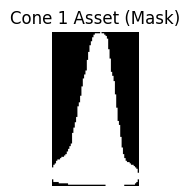

  [Debug] Found 1 contours for cone 1.
  Successfully spawned cone 1 at (82, 443) with 108 points.

--- PREVIEW: Cone 1 (with its generated ground truth) ---


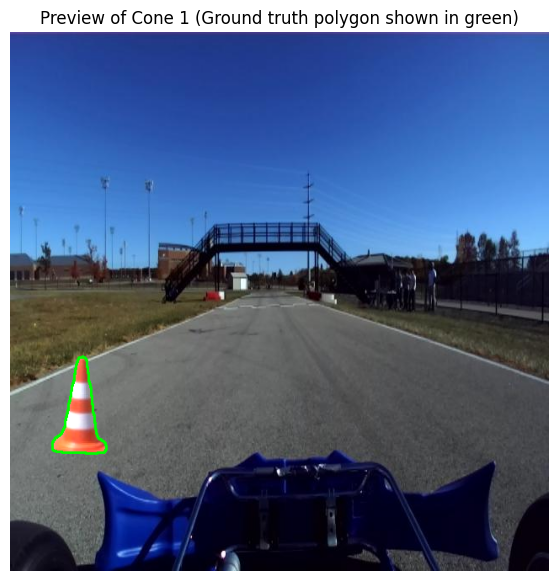

  Ground Truth .txt line for this cone:
  1 0.134375 0.601562 0.132812 0.603125 0.128125 0.603125 0.126563 0.604688 0.126563 0.60625...

--- FINAL PREVIEW: SYNTHETIC IMAGE (ALL CONES) ---
This is the final 'clean' image that would be saved.


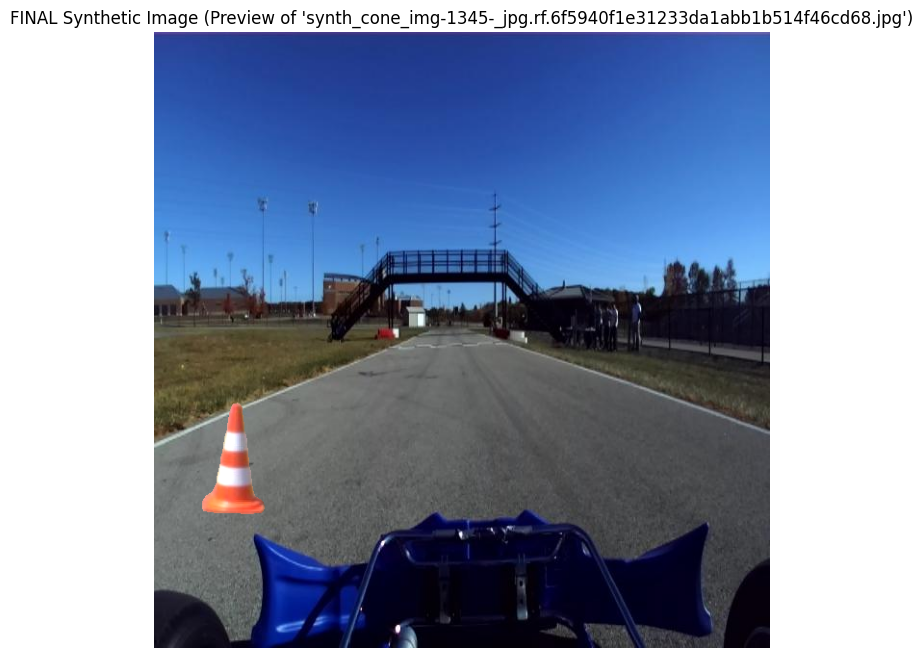


--- FINAL PREVIEW: GROUND TRUTH .TXT CONTENTS ---
This is the full text file that would be saved.
(Drivable)   0 0.998438 0.656250 0.507812 0.481250 0.457812 0.481250 0.000000 0.671875 0.0000...
(New Cone) 1 0.134375 0.601562 0.132812 0.603125 0.128125 0.603125 0.126563 0.604688 0.1265...

--- PREVIEW SCRIPT FINISHED ---


In [ ]:
# Preview Mode, v8 - With Pixel Count

print(f"--- STARTING PREVIEW MODE ---")
print(f"Loading one random image to process...")

# Get One Random Background Image
background_images = [f for f in os.listdir(BG_IMAGE_DIR) if f.endswith(('.jpg', '.png'))]
if not background_images:
    print("[!! ERROR !!] No background images found. Cannot run preview.")
else:
    img_filename = random.choice(background_images)
    print(f"Processing: {img_filename}")

    # Load Background Image & Labels
    img_path = os.path.join(BG_IMAGE_DIR, img_filename)
    label_filename = os.path.splitext(img_filename)[0] + '.txt'
    label_path = os.path.join(BG_LABEL_DIR, label_filename)

    if not os.path.exists(label_path):
        print(f"  [Skipping] Label file not found: {label_filename}")
    else:
        bg_img = cv2.imread(img_path)
        if bg_img is None:
            print(f"  [Skipping] Could not read image: {img_filename}")
        else:
            img_h, img_w, _ = bg_img.shape

            # Load all original polygons (lanes, etc.)
            original_annotations = load_yolo_segmentation(label_path, img_w, img_h)

            # Get Valid Spawn Mask
            spawnable_mask = get_spawnable_mask(original_annotations, img_h, img_w)

            if spawnable_mask is None:
                print(f"  [Skipping] No drivable area found in this image.")
            else:
                valid_spawn_pixels = np.argwhere(spawnable_mask == 1)

                if len(valid_spawn_pixels) == 0:
                    print(f"  [Skipping] No valid spawn pixels (drivable path is not in the 50-75% region).")
                else:
                    # Prepare for Pasting
                    synthetic_img = bg_img.copy()
                    new_annotations = list(original_annotations)

                    num_cones_to_spawn = random.randint(MIN_CONES_PER_IMG, MAX_CONES_PER_IMG)
                    print(f"  Attempting to spawn {num_cones_to_spawn} cone(s)...")

                    # Spawn Loop
                    for i in range(num_cones_to_spawn):
                        print("-" * 40) # Separator for each cone
                        cone_asset = random.choice(cone_assets)

                        cone_aug, mask_aug = augment_and_resize_cone(cone_asset, img_h)

                        if cone_aug is None:
                            print(f"  [Warning] Cone {i+1} was too small. Skipping.")
                            continue

                        cone_h, cone_w = cone_aug.shape[:2]

                        print(f"\n--- PREVIEW: Asset for Cone {i+1} (Scaled/Augmented) ---")
                        print(f"  (This is the small image being pasted, size: {cone_w}x{cone_h})")
                        cone_rgb_preview = cv2.cvtColor(cone_aug, cv2.COLOR_BGR2RGB)
                        plt.figure(figsize=(2, 2)) # Small figure size
                        plt.imshow(cone_rgb_preview)
                        plt.title(f"Cone {i+1} Asset (Image)")
                        plt.axis('off')
                        plt.show()

                        print(f"\n--- PREVIEW: Mask for Cone {i+1} (Scaled/Augmented) ---")
                        print(f"  (This is the small MASK being used, size: {cone_w}x{cone_h})")

                        white_pixel_count = cv2.countNonZero(mask_aug)
                        print(f"  [Debug] White Pixel Count in this asset: {white_pixel_count}")

                        if white_pixel_count == 0:
                            print("  [!! DEBUG WARNING !!] This mask asset is all black. Skipping.")
                            continue

                        plt.figure(figsize=(2, 2)) # Small figure size
                        plt.imshow(mask_aug, cmap='gray') # Show in grayscale
                        plt.title(f"Cone {i+1} Asset (Mask)")
                        plt.axis('off')
                        plt.show()

                        spawn_x_tl = spawn_center_coords[0] - (cone_w // 2)
                        spawn_y_tl = spawn_center_coords[1] - (cone_h // 2)
                        pasting_mask = np.zeros((img_h, img_w), dtype=np.uint8)

                        bg_x1 = max(0, spawn_x_tl)
                        bg_y1 = max(0, spawn_y_tl)
                        bg_x2 = min(img_w, spawn_x_tl + cone_w)
                        bg_y2 = min(img_h, spawn_y_tl + cone_h)

                        if (bg_x1 >= bg_x2) or (bg_y1 >= bg_y2):
                            print(f"  [Warning] Cone {i+1} spawned completely off-screen. Skipping.")
                            continue

                        cone_x1 = max(0, -spawn_x_tl)
                        cone_y1 = max(0, -spawn_y_tl)
                        cone_x2 = cone_x1 + (bg_x2 - bg_x1)
                        cone_y2 = cone_y1 + (bg_y2 - bg_y1)

                        # Create the new ground truth mask
                        pasting_mask[bg_y1:bg_y2, bg_x1:bg_x2] = mask_aug[cone_y1:cone_y2, cone_x1:cone_x2]

                        try:
                            roi = synthetic_img[bg_y1:bg_y2, bg_x1:bg_x2]
                            cone_to_paste = cone_aug[cone_y1:cone_y2, cone_x1:cone_x2]
                            mask_to_paste = mask_aug[cone_y1:cone_y2, cone_x1:cone_x2]
                            mask_inv = cv2.bitwise_not(mask_to_paste)
                            bg_part = cv2.bitwise_and(roi, roi, mask=mask_inv)
                            cone_part = cv2.bitwise_and(cone_to_paste, cone_to_paste, mask=mask_to_paste)
                            blended_roi = cv2.add(bg_part, cone_part)
                            synthetic_img[bg_y1:bg_y2, bg_x1:bg_x2] = blended_roi
                        except Exception as e:
                            print(f"  [Error] Cone {i+1} failed to paste (ROI calculation error). Skipping. {e}")
                            continue

                        # Get NEW Ground Truth & Display Separately
                        contours, _ = cv2.findContours(pasting_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                        print(f"  [Debug] Found {len(contours)} contours for cone {i+1}.")

                        if not contours:
                            print(f"  [Warning] Cone {i+1} was pasted, but no contour was found. Skipping.")
                            continue

                        for contour in contours:
                            area = cv2.contourArea(contour)

                            if area < 20:
                                print(f"  [Debug] Skipping contour with area {area} (too small).")
                                continue

                            epsilon = 0.0005 * cv2.arcLength(contour, True)
                            approx_poly = cv2.approxPolyDP(contour, epsilon, True)
                            polygon_pixels = approx_poly.reshape(-1, 2)

                            if len(polygon_pixels) < 3:
                                print(f"  [Debug] Skipping polygon with {len(polygon_pixels)} points (need at least 3). Epsilon was {epsilon}.")
                                continue

                            # Add to the main list
                            new_annotations.append((CONE_CLASS_ID, polygon_pixels))
                            print(f"  Successfully spawned cone {i+1} at ({spawn_x}, {spawn_y}) with {len(polygon_pixels)} points.")

                            print(f"\n--- PREVIEW: Cone {i+1} (with its generated ground truth) ---")

                            preview_img = synthetic_img.copy()
                            cv2.drawContours(preview_img, [polygon_pixels], -1, (0, 255, 0), 2) # Bright Green (BGR)

                            img_rgb_preview = cv2.cvtColor(preview_img, cv2.COLOR_BGR2RGB)
                            plt.figure(figsize=(10, 7))
                            plt.imshow(img_rgb_preview)
                            plt.title(f"Preview of Cone {i+1} (Ground truth polygon shown in green)")
                            plt.axis('off')
                            plt.show()



                            norm_coords = polygon_pixels.astype(np.float32)
                            norm_coords_copy = norm_coords.copy()
                            norm_coords_copy[:, 0] = np.clip(norm_coords_copy[:, 0] / img_w, 0, 1)
                            norm_coords_copy[:, 1] = np.clip(norm_coords_copy[:, 1] / img_h, 0, 1)
                            coord_str = " ".join([f"{coord:.6f}" for coord in norm_coords_copy.flatten()])
                            line = f"{CONE_CLASS_ID} {coord_str}"
                            print(f"  Ground Truth .txt line for this cone:\n  {line[:90]}...")


                    # Display FINAL Results
                    print("\n" + "="*50)
                    print("--- FINAL PREVIEW: SYNTHETIC IMAGE (ALL CONES) ---")
                    print("This is the final 'clean' image that would be saved.")
                    img_rgb = cv2.cvtColor(synthetic_img, cv2.COLOR_BGR2RGB)
                    plt.figure(figsize=(12, 8))
                    plt.imshow(img_rgb)
                    plt.title(f"FINAL Synthetic Image (Preview of 'synth_cone_{img_filename}')")
                    plt.axis('off')
                    plt.show()

                    print("\n--- FINAL PREVIEW: GROUND TRUTH .TXT CONTENTS ---")
                    print("This is the full text file that would be saved.")
                    output_text_lines = []
                    for class_id, pixel_coords in new_annotations:
                        if len(pixel_coords) < 3: continue

                        norm_coords = pixel_coords.astype(np.float32)
                        norm_coords[:, 0] = np.clip(norm_coords[:, 0] / img_w, 0, 1)
                        norm_coords[:, 1] = np.clip(norm_coords[:, 1] / img_h, 0, 1)

                        coord_str = " ".join([f"{coord:.6f}" for coord in norm_coords.flatten()])
                        line = f"{class_id} {coord_str}"
                        output_text_lines.append(line)

                        if class_id == CONE_CLASS_ID:
                            print(f"(New Cone) {line[:80]}...")
                        elif class_id == DRIVABLE_CLASS_ID:
                            print(f"(Drivable)   {line[:80]}...")
                        else:
                            print(f"(Other)      {line[:80]}...")

                    if not output_text_lines:
                        print("(No valid annotations found or generated)")

print("\n--- PREVIEW SCRIPT FINISHED ---")